In [2]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

traffic_datafile17 = "../Resources/2017_traffic_atr_volume.csv"
traffic_datafile18 = "../Resources/2018_traffic_atr_volume.csv"
traffic_datafile19 = "../Resources/2019_traffic_atr_volume.csv"
traffic_datafile20 = "../Resources/2020_traffic_atr_volume.csv"
traffic_data = pd.read_csv(traffic_datafile)
traffic_data = traffic_data.rename(columns={"station_id": "Station ID", 'dir_of_travel': 'Direction of Travel', 'lane_of_travel': 'Lane of Travel', 'date': 'Date'})
#traffic_data['Daily']

traffic_data.head()

,Station ID,Direction of Travel,Lane of Travel,Date,1,2,3,4,5,6,...,15,16,17,18,19,20,21,22,23,24
0,26,1,1,2020-01-01,55,63,43,40,35,57,...,487,458,466,372,330,272,209,153,114,86
1,26,1,2,2020-01-01,3,7,3,7,5,7,...,198,195,220,133,95,85,54,28,22,15
2,26,5,1,2020-01-01,59,54,39,52,45,63,...,469,430,434,361,312,229,190,145,70,49
3,26,5,2,2020-01-01,8,2,3,5,5,4,...,207,204,195,146,109,79,37,21,15,7
4,26,1,1,2020-01-02,66,49,62,71,131,209,...,460,465,424,392,312,218,196,192,159,102


In [3]:
traffic_condensed = pd.DataFrame({'Station ID': traffic_data['Station ID'], 'Date': traffic_data['Date']})
traffic_condensed['Daily Traffic Volume'] = traffic_data.iloc[:, 4:28].sum(axis=1)
traffic_condensed

,Station ID,Date,Daily Traffic Volume
0,26,2020-01-01,5335
1,26,2020-01-01,1634
2,26,2020-01-01,5953
3,26,2020-01-01,2257
4,26,2020-01-02,6434
...,...,...,...
45774,6224,2020-09-29,395
45775,6224,2020-09-30,4886
45776,6224,2020-09-30,1239
45777,6224,2020-09-30,4679


In [4]:

daily_total20 = traffic_condensed20.groupby('Date').sum()['Daily Traffic Volume']
traffic_daily20 = pd.DataFrame({"Daily Traffic Volume": daily_total})
traffic_daily20

,Daily Traffic Volume
Date,
2020-01-01,396330
2020-01-02,698650
2020-01-03,704508
2020-01-04,627165
2020-01-05,498698
...,...
2020-09-26,611795
2020-09-27,542670
2020-09-28,632263


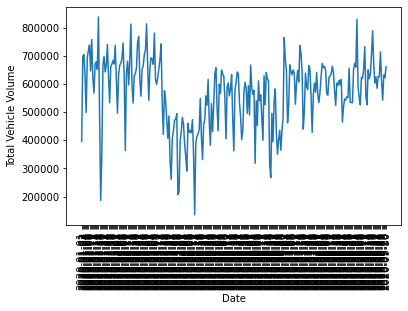

In [8]:
months = mdates.MonthLocator()
x = traffic_daily20.index
y = traffic_daily20['Daily Traffic Volume']



plt.plot(x,y)
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Total Vehicle Volume')
plt.show()